installed packages:
- Numpy
- Matplotlib
- Cython
- Pythran
- colorlog

In [35]:
%matplotlib inline

In [42]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (12, 8)

In [4]:
import time
import numpy as np

def iterate(c, n=100):
    z = 0
    for i in range(n):
        z = z ** 2 + c
        x = z.real
        y = z.imag
        if x ** 2 + y ** 2 > 4:
            break
    return i

def mandelbrot(xs, ys):
    escape = np.empty((len(xs), len(ys)))
    for i in range(len(xs)):
        for j in range(len(ys)):
            z = xs[i] + 1j * ys[j]
            escape[i, j] = iterate(z)
    return escape


In [106]:
def run_and_show(fun, nx=2000, ny=2000):
    xs = np.linspace(-2, 1, nx)
    ys = np.linspace(-1, 1, ny)
    start = time.time()
    Z = fun(xs, ys)
    stop = time.time()

    print(f"Total run time: {stop - start:.02f}s")
    plt.imshow(Z)

Total run time: 2.31s


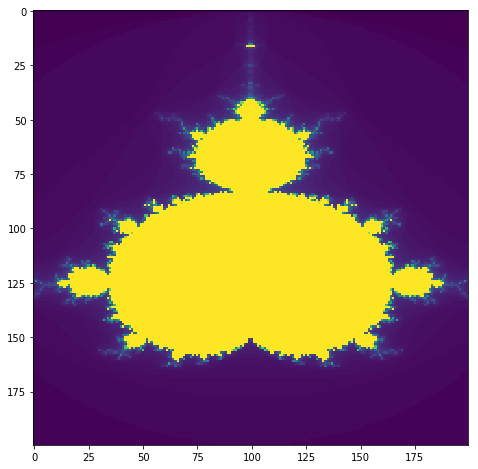

In [107]:
run_and_show(mandelbrot, nx=200, ny=200)

In [89]:
import cython

cython.__version__

'0.29'

In [90]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [109]:
%%cython
#cython: language_level=3, boundscheck=False

import cython
import numpy as np
cimport numpy as cnp

cdef int iterate(double complex c, int n=100):
    cdef:
        double complex z
        double x, y
        int i
    z = 0
    for i in range(n):
        z = z ** 2 + c
        x = z.real
        y = z.imag
        if x ** 2 + y ** 2 > 4:
            break
    return i


# TODO figure out the right "cython" type for the return value

def mandelbrot_cython(xs: cython.double[:], ys: cython.double[:]) -> np.int64_t[:, :]:
    escape: np.int64_t[:, :]
    i: cython.int
    j: cython.int
    z: cython.complex
    
    escape = np.empty((len(xs), len(ys)), dtype=np.int64)
    for i in range(xs.shape[0]):
        for j in range(ys.shape[0]):
            z = xs[i] + 1j * ys[j]
            escape[i, j] = iterate(z)
    return escape


Total run time: 0.93s


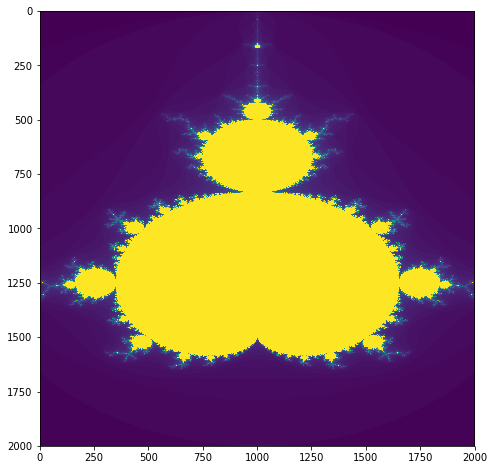

In [110]:
run_and_show(mandelbrot_cython)

Numba
---

Euler formula for $\pi$.

In [9]:
def compute_pi(n):
    acc = 0
    for k in range(n):
        acc += 1/(k + 1)**2
    return (6*acc)**0.5

In [12]:
for n in [10, 100, 1000, 10000, 100000]:
    print(n, compute_pi(n))

10 3.04936163598207
100 3.1320765318091053
1000 3.1406380562059946
10000 3.1414971639472147
100000 3.141583104326456


In [1]:
import dis

In [13]:
dis.dis(compute_pi)

  2           0 LOAD_CONST               1 (0)
              2 STORE_FAST               1 (acc)

  3           4 SETUP_LOOP              36 (to 42)
              6 LOAD_GLOBAL              0 (range)
              8 LOAD_FAST                0 (n)
             10 CALL_FUNCTION            1
             12 GET_ITER
        >>   14 FOR_ITER                24 (to 40)
             16 STORE_FAST               2 (k)

  4          18 LOAD_FAST                1 (acc)
             20 LOAD_CONST               2 (1)
             22 LOAD_FAST                2 (k)
             24 LOAD_CONST               2 (1)
             26 BINARY_ADD
             28 LOAD_CONST               3 (2)
             30 BINARY_POWER
             32 BINARY_TRUE_DIVIDE
             34 INPLACE_ADD
             36 STORE_FAST               1 (acc)
             38 JUMP_ABSOLUTE           14
        >>   40 POP_BLOCK

  5     >>   42 LOAD_CONST               4 (6)
             44 LOAD_FAST                1 (acc)
             46 

In [18]:
import numba

In [71]:
from IPython.core import magic_arguments
from IPython.core.magic import cell_magic, Magics, magics_class

import subprocess
import tempfile

@magics_class
class NumbaMagics(Magics):
    @cell_magic
    def numba_with_env(self, line='', cell=None):
        with tempfile.NamedTemporaryFile() as fd:
            fd.write(cell.encode())
            fd.flush()
            print(f"{line} python {fd.name}")
            output = subprocess.check_output(f"{line} python {fd.name}", shell=True)
        print(output.decode())

ip = get_ipython()
ip.register_magics(NumbaMagics)

In [72]:
%%numba_with_env NUMBA_DUMP_CFG=1

import numba

@numba.jit('float64(int64)')
def compute_pi(n):
    acc = 0
    for k in range(n):
        acc += 1/(k + 1)**2
    return (6*acc)**0.5

NUMBA_DUMP_CFG=1 python /var/folders/yx/p6tl77d502qc2v1srt84n91r0000gq/T/tmpw85sfy16
CFG adjacency lists:
{0: [4], 4: [6], 6: [14], 14: [40, 16], 16: [14], 40: [42], 42: []}
CFG dominators:
{0: {0},
 4: {0, 4},
 6: {0, 4, 6},
 14: {0, 4, 14, 6},
 16: {0, 4, 6, 14, 16},
 40: {0, 4, 6, 40, 14},
 42: {0, 4, 6, 40, 42, 14}}
CFG post-dominators:
{0: {0, 4, 6, 40, 42, 14},
 4: {4, 6, 40, 42, 14},
 6: {40, 42, 6, 14},
 14: {40, 42, 14},
 16: {16, 40, 42, 14},
 40: {40, 42},
 42: {42}}
CFG back edges: [(16, 14)]
CFG loops:
{14: Loop(entries={6}, exits={40}, header=14, body={16, 14})}
CFG node-to-loops:
{0: [], 4: [], 6: [], 14: [14], 16: [14], 40: [], 42: []}



In [73]:
%%numba_with_env NUMBA_DUMP_IR=1

import numba

@numba.jit('float64(int64)')
def compute_pi(n):
    acc = 0
    for k in range(n):
        acc += 1/(k + 1)**2
    return (6*acc)**0.5

NUMBA_DUMP_IR=1 python /var/folders/yx/p6tl77d502qc2v1srt84n91r0000gq/T/tmpu1w7x02b
CFG adjacency lists:
{0: [4], 4: [6], 6: [14], 14: [40, 16], 16: [14], 40: [42], 42: []}
CFG dominators:
{0: {0},
 4: {0, 4},
 6: {0, 4, 6},
 14: {0, 4, 14, 6},
 16: {0, 4, 6, 14, 16},
 40: {0, 4, 6, 40, 14},
 42: {0, 4, 6, 40, 42, 14}}
CFG post-dominators:
{0: {0, 4, 6, 40, 42, 14},
 4: {4, 6, 40, 42, 14},
 6: {40, 42, 6, 14},
 14: {40, 42, 14},
 16: {16, 40, 42, 14},
 40: {40, 42},
 42: {42}}
CFG back edges: [(16, 14)]
CFG loops:
{14: Loop(entries={6}, exits={40}, header=14, body={16, 14})}
CFG node-to-loops:
{0: [], 4: [], 6: [], 14: [14], 16: [14], 40: [], 42: []}
------------------------------IR DUMP: compute_pi-------------------------------
label 0:
    n = arg(0, name=n)                       ['n']
    $const0.1 = const(int, 0)                ['$const0.1']
    acc = $const0.1                          ['$const0.1', 'acc']
    del $const0.1                            []
    jump 4                 

In [74]:
%%numba_with_env NUMBA_DUMP_ANNOTATION=1

import numba

@numba.jit('float64(int64)')
def compute_pi(n):
    acc = 0
    for k in range(n):
        acc += 1/(k + 1)**2
    return (6*acc)**0.5

NUMBA_DUMP_ANNOTATION=1 python /var/folders/yx/p6tl77d502qc2v1srt84n91r0000gq/T/tmprsyz8xlu
CFG adjacency lists:
{0: [4], 4: [6], 6: [14], 14: [40, 16], 16: [14], 40: [42], 42: []}
CFG dominators:
{0: {0},
 4: {0, 4},
 6: {0, 4, 6},
 14: {0, 4, 14, 6},
 16: {0, 4, 6, 14, 16},
 40: {0, 4, 6, 40, 14},
 42: {0, 4, 6, 40, 42, 14}}
CFG post-dominators:
{0: {0, 4, 6, 40, 42, 14},
 4: {4, 6, 40, 42, 14},
 6: {40, 42, 6, 14},
 14: {40, 42, 14},
 16: {16, 40, 42, 14},
 40: {40, 42},
 42: {42}}
CFG back edges: [(16, 14)]
CFG loops:
{14: Loop(entries={6}, exits={40}, header=14, body={16, 14})}
CFG node-to-loops:
{0: [], 4: [], 6: [], 14: [14], 16: [14], 40: [], 42: []}
-----------------------------------ANNOTATION-----------------------------------
# File: /var/folders/yx/p6tl77d502qc2v1srt84n91r0000gq/T/tmprsyz8xlu
# --- LINE 4 --- 
# label 0

@numba.jit('float64(int64)')

# --- LINE 5 --- 

def compute_pi(n):

    # --- LINE 6 --- 
    #   n = arg(0, name=n)  :: int64
    #   $const0.1 = const(

In [75]:
%%numba_with_env NUMBA_DUMP_LLVM=1

import numba

@numba.jit('float64(int64)')
def compute_pi(n):
    acc = 0
    for k in range(n):
        acc += 1/(k + 1)**2
    return (6*acc)**0.5

NUMBA_DUMP_LLVM=1 python /var/folders/yx/p6tl77d502qc2v1srt84n91r0000gq/T/tmpe4d3mfkh
CFG adjacency lists:
{0: [4], 4: [6], 6: [14], 14: [40, 16], 16: [14], 40: [42], 42: []}
CFG dominators:
{0: {0},
 4: {0, 4},
 6: {0, 4, 6},
 14: {0, 4, 14, 6},
 16: {0, 4, 6, 14, 16},
 40: {0, 4, 6, 40, 14},
 42: {0, 4, 6, 40, 42, 14}}
CFG post-dominators:
{0: {0, 4, 6, 40, 42, 14},
 4: {4, 6, 40, 42, 14},
 6: {40, 42, 6, 14},
 14: {40, 42, 14},
 16: {16, 40, 42, 14},
 40: {40, 42},
 42: {42}}
CFG back edges: [(16, 14)]
CFG loops:
{14: Loop(entries={6}, exits={40}, header=14, body={16, 14})}
CFG node-to-loops:
{0: [], 4: [], 6: [], 14: [14], 16: [14], 40: [], 42: []}
-----------------LLVM DUMP <function descriptor 'compute_pi$1'>-----------------
; ModuleID = "compute_pi$1"
target triple = "x86_64-apple-darwin17.7.0"
target datalayout = "e-m:o-i64:64-f80:128-n8:16:32:64-S128"

@"_ZN08NumbaEnv8__main__14compute_pi$241Ex" = common global i8* null
define i32 @"_ZN8__main__14compute_pi$241Ex"(double* noa

In [76]:
%%numba_with_env NUMBA_DUMP_ASSEMBLY=1

import numba

@numba.jit('float64(int64)')
def compute_pi(n):
    acc = 0
    for k in range(n):
        acc += 1/(k + 1)**2
    return (6*acc)**0.5

NUMBA_DUMP_ASSEMBLY=1 python /var/folders/yx/p6tl77d502qc2v1srt84n91r0000gq/T/tmpa46tgag9
----------------------------------ASSEMBLY nrt----------------------------------
	.section	__TEXT,__text,regular,pure_instructions
	.macosx_version_min 10, 13
	.globl	_nrt_atomic_add
	.p2align	4, 0x90
_nrt_atomic_add:
	movl	$1, %eax
	lock		xaddq	%rax, (%rdi)
	addq	$1, %rax
	retq

	.globl	_nrt_atomic_sub
	.p2align	4, 0x90
_nrt_atomic_sub:
	movq	$-1, %rax
	lock		xaddq	%rax, (%rdi)
	addq	$-1, %rax
	retq

	.globl	_nrt_atomic_cas
	.p2align	4, 0x90
_nrt_atomic_cas:
	xorl	%r8d, %r8d
	movq	%rsi, %rax
	lock		cmpxchgq	%rdx, (%rdi)
	sete	%r8b
	movq	%rax, (%rcx)
	movl	%r8d, %eax
	retq

	.globl	_NRT_MemInfo_data_fast
	.p2align	4, 0x90
_NRT_MemInfo_data_fast:
	movq	24(%rdi), %rax
	retq

	.globl	_NRT_incref
	.p2align	4, 0x90
_NRT_incref:
	testq	%rdi, %rdi
	je	LBB4_1
	lock		addq	$1, (%rdi)
	retq
LBB4_1:
	retq

	.globl	_NRT_decref
	.p2align	4, 0x90
_NRT_decref:
	.cfi_startproc
	testq	%rdi, %rdi
	je	LBB5_2
	##MEMBA

Pythran
---

Needs C++11 compiler

In [111]:
%load_ext pythran.magic

In [114]:
%%pythran
#pythran export foo()
def foo():
    print('hello')

In [116]:
foo()  # Where is my hello?

In [145]:
%%pythran
# pythran export iterate_pythran(complex128, int)

import numpy as np

def iterate_pythran(c, n=100):
    z = 0
    for i in range(n):
        z = z ** 2 + c
        x = z.real
        y = z.imag
        if x ** 2 + y ** 2 > 4:
            break
    return i

# pythran export mandelbrot_pythran(float[], float[])

def mandelbrot_pythran(xs, ys):
    escape = np.empty((len(xs), len(ys)))
    for i in range(len(xs)):
        for j in range(len(ys)):
            z = xs[i] + 1j * ys[j]
            escape[i, j] = iterate_pythran(z)
    return escape


In [138]:
%timeit iterate_pythran(1.2j, 100)

221 ns ± 1.91 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [139]:
%timeit iterate(1.2j, 100)

1.59 µs ± 9.84 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Total run time: 1.07s


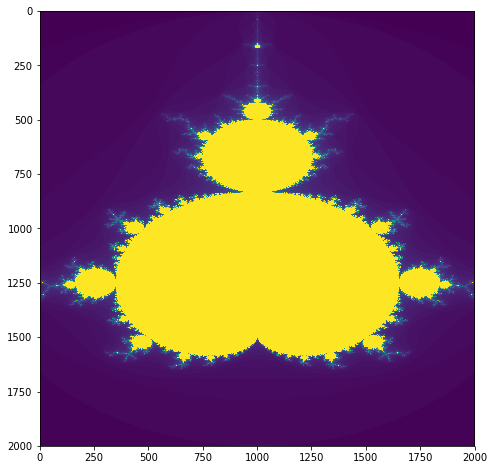

In [148]:
run_and_show(mandelbrot_pythran, nx=2000, ny=2000)